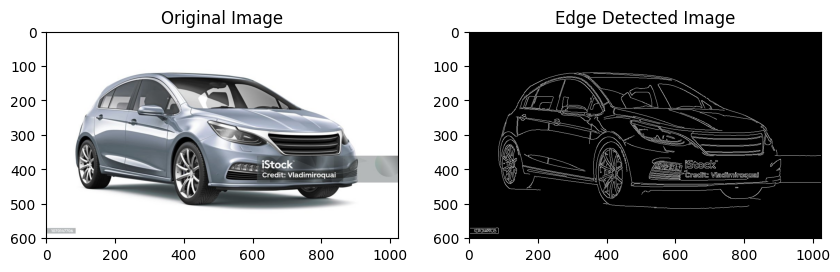

In [34]:
import cv2
import matplotlib.pyplot as plt

# image without background 

frame = cv2.imread('car.jpg')

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

blurred = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0.5) 

edges = cv2.Canny(blurred, 100, 300) 

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Edge Detected Image')
plt.imshow(edges, cmap='gray')

plt.show()

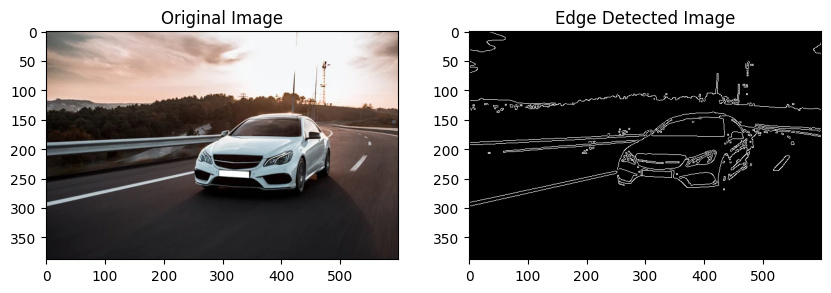

In [35]:
frame = cv2.imread('car1.jpg')

gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

thresholdValue, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

background_mask = cv2.bitwise_not(mask)

blurred = cv2.GaussianBlur(src=mask, ksize=(5, 5), sigmaX=0.5) 

edges = cv2.Canny(blurred, 100, 300) 

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

plt.subplot(1, 2, 2)
plt.title('Edge Detected Image')
plt.imshow(edges, cmap='gray')

plt.show()


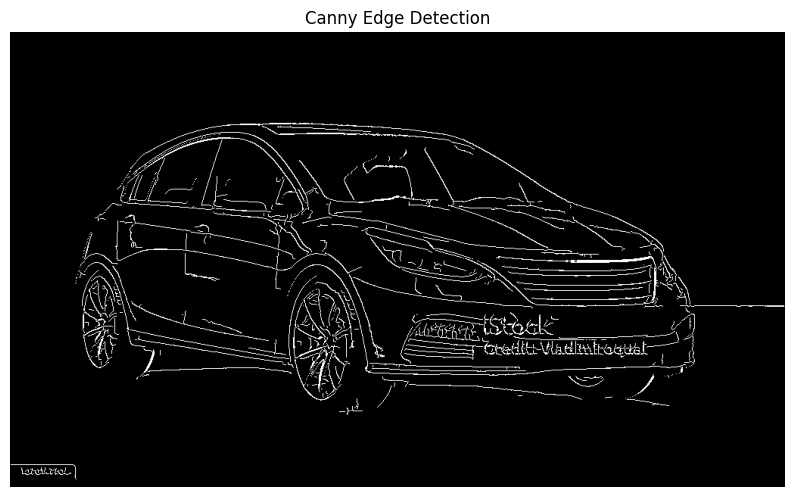

In [1]:
import numpy as np
import cv2
import cv2
import cv2
import matplotlib.pyplot as plt

image = cv2.imread('car.jpg')

def gaussian_kernel(size, sigma=1):
    """Generate a Gaussian kernel."""
    kernel = np.fromfunction(
        lambda x, y: (1 / (2 * np.pi * sigma ** 2)) * 
        np.exp(- ((x - (size - 1) / 2) ** 2 + (y - (size - 1) / 2) ** 2) / (2 * sigma ** 2)),
        (size, size)
    )
    return kernel / np.sum(kernel)

def apply_filter(image, kernel):
    """Apply a filter using convolution."""
    return cv2.filter2D(image, -1, kernel)

def sobel_filters(image):
    """Compute Sobel gradients."""
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    
    Ix = cv2.filter2D(image, -1, Kx)
    Iy = cv2.filter2D(image, -1, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return G, theta

def non_max_suppression(gradient, direction):
    """Suppress non-maximum gradients."""
    M, N = gradient.shape
    output = np.zeros((M, N), dtype=np.int32)
    angle = direction * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1, M - 1):
        for j in range(1, N - 1):
            try:
                q = 255
                r = 255

                
                if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                    q = gradient[i, j + 1]
                    r = gradient[i, j - 1]
                
                elif 22.5 <= angle[i, j] < 67.5:
                    q = gradient[i + 1, j - 1]
                    r = gradient[i - 1, j + 1]
                
                elif 67.5 <= angle[i, j] < 112.5:
                    q = gradient[i + 1, j]
                    r = gradient[i - 1, j]
                
                elif 112.5 <= angle[i, j] < 157.5:
                    q = gradient[i - 1, j - 1]
                    r = gradient[i + 1, j + 1]

                if (gradient[i, j] >= q) and (gradient[i, j] >= r):
                    output[i, j] = gradient[i, j]
                else:
                    output[i, j] = 0

            except IndexError as e:
                pass

    return output

def threshold(image, low, high):
    """Apply double threshold."""
    high_threshold = image.max() * high
    low_threshold = high_threshold * low

    M, N = image.shape
    res = np.zeros((M, N), dtype=np.int32)

    strong = np.int32(255)
    weak = np.int32(75)

    strong_i, strong_j = np.where(image >= high_threshold)
    weak_i, weak_j = np.where((image <= high_threshold) & (image >= low_threshold))

    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak

    return res, weak, strong

def hysteresis(img, weak, strong=255):
    """Track edges by hysteresis."""
    M, N = img.shape
    for i in range(1, M - 1):
        for j in range(1, N - 1):
            if img[i, j] == weak:
                if ((img[i + 1, j - 1] == strong) or (img[i + 1, j] == strong) or 
                    (img[i + 1, j + 1] == strong) or (img[i, j - 1] == strong) or 
                    (img[i, j + 1] == strong) or (img[i - 1, j - 1] == strong) or 
                    (img[i - 1, j] == strong) or (img[i - 1, j + 1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

def canny_edge_detection(image, low_threshold, high_threshold):
    """Perform the Canny Edge Detection algorithm."""
    
    smoothed = apply_filter(image, gaussian_kernel(5, 1))

    
    gradient, theta = sobel_filters(smoothed)

    
    non_max = non_max_suppression(gradient, theta)

    
    threshold_img, weak, strong = threshold(non_max, low_threshold, high_threshold)

    
    img_final = hysteresis(threshold_img, weak, strong)

    return img_final

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt


image = cv2.imread('car.jpg', cv2.IMREAD_GRAYSCALE)


if image is None:
    raise FileNotFoundError("The image file was not found. Please check the path.")


edges = canny_edge_detection(image, low_threshold=0.05, high_threshold=0.15)


plt.figure(figsize=(10, 8))
plt.imshow(edges, cmap='gray')
plt.imshow(edges, cmap='gray')
plt.title('Canny Edge Detection')
plt.axis('off')
plt.show()
